In [1]:
from torchvision import transforms
import torchvision.transforms.functional as F
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch

import numpy as np
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
import random

In [ ]:
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [2]:
class ImageDataset(Dataset):
    def __init__(self, image_data, labels, transform=None):
        """
        Args:
            image_data (torch.Tensor): A tensor of shape (N, 1, 128, 128) containing the images.
            labels (torch.Tensor): A tensor of shape (N,) containing the labels.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.image_data = torch.tensor(image_data, dtype = torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)
        self.transform = transform

    def __len__(self):
        return len(self.image_data)

    def __getitem__(self, idx):
        image = self.image_data[idx]  # Shape: (1, 128, 128)
        label = self.labels[idx]

        # Convert single-channel image to 3-channel by copying the channel
        image = image.repeat(3, 1, 1)  # Shape: (3, 128, 128)

        if self.transform:
            image = self.transform(image)

        return image, label

class RandomRotation:
    def __init__(self, degrees, p=0.5):
        self.degrees = degrees
        self.p = p

    def __call__(self, img):
        if random.random() < self.p:
            angle = random.uniform(-self.degrees, self.degrees)
            img = F.rotate(img, angle)
        return img

class RandomGaussianBlur:
    def __init__(self, kernel_size, sigma=(0.1, 2.0), p=0.5):
        self.kernel_size = kernel_size
        self.sigma = sigma
        self.p = p

    def __call__(self, img):
        if random.random() < self.p:
            img = F.gaussian_blur(img, self.kernel_size, self.sigma)
        return img

class RandomNoise:
    def __init__(self, mean=0, std=0.1, p=0.5):
        self.mean = mean
        self.std = std
        self.p = p

    def __call__(self, img):
        if random.random() < self.p:
            noise = torch.randn_like(img) * self.std + self.mean
            img = img + noise
            img = torch.clamp(img, 0, 1)  # Clamp values to [0, 1] range
        return img

# Define the transformations
transform = transforms.Compose([
    RandomRotation(degrees=30, p=0.5),
    RandomGaussianBlur(kernel_size=3, sigma=(0.1, 2.0), p=1),
    RandomNoise(mean=0, std=0.1, p=1),
])

In [3]:
model = models.resnet50(pretrained = True)
resnet50 = torch.nn.Sequential(*list(model.children())[:-1], nn.Flatten(), nn.Linear(2048, 100))

# Load data
train_data = np.load("data/train.npz")
test_data = np.load("data/test.npz")

# Create datasets and dataloaders
train_dataset = ImageDataset(train_data["data"], train_data["labels"], transform=transform)
test_dataset = ImageDataset(test_data["data"], test_data["labels"], transform=transform)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # For classification tasks
optimizer = optim.Adam(resnet50.parameters(), lr=0.001)

# Training loop
num_epochs = 10
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet50.to(device)  # Move model to GPU if available

train_losses = list()
test_losses = list()
test_accs = list()

for epoch in range(num_epochs):
    # Training phase
    resnet50.train()  # Set model to training mode
    running_loss = 0.0

    for inputs, labels in train_dataloader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = resnet50(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Accumulate loss
        running_loss += loss.item() * inputs.size(0)

    # Calculate training loss for the epoch
    epoch_loss = running_loss / len(train_dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}")

    # Evaluation phase
    resnet50.eval()  # Set model to evaluation mode
    test_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient computation
        for inputs, labels in test_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = resnet50(inputs)
            loss = criterion(outputs, labels)

            # Accumulate test loss
            test_loss += loss.item() * inputs.size(0)

            # Get predictions
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calculate test loss and accuracy
    test_loss = test_loss / len(test_dataset)
    test_accuracy = accuracy_score(all_labels, all_preds)
    print(f"Epoch [{epoch+1}/{num_epochs}], Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    train_losses.append(epoch_loss)
    test_losses.append(test_loss)
    test_accs.append(test_accuracy)

print("Training complete!")

c:\Users\MONSTER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\MONSTER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\MONSTER\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\autograd\graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ..\aten\src\ATen

Epoch [1/10], Train Loss: 2.4621
Epoch [1/10], Test Loss: 0.9366, Test Accuracy: 0.7300
Epoch [2/10], Train Loss: 0.4688
Epoch [2/10], Test Loss: 0.8715, Test Accuracy: 0.7700
Epoch [3/10], Train Loss: 0.2766
Epoch [3/10], Test Loss: 0.4956, Test Accuracy: 0.8610
Epoch [4/10], Train Loss: 0.2171
Epoch [4/10], Test Loss: 0.3681, Test Accuracy: 0.9090
Epoch [5/10], Train Loss: 0.1601
Epoch [5/10], Test Loss: 0.1953, Test Accuracy: 0.9400
Epoch [6/10], Train Loss: 0.1250
Epoch [6/10], Test Loss: 0.2606, Test Accuracy: 0.9180
Epoch [7/10], Train Loss: 0.1385
Epoch [7/10], Test Loss: 0.3393, Test Accuracy: 0.9050
Epoch [8/10], Train Loss: 0.1399
Epoch [8/10], Test Loss: 0.2689, Test Accuracy: 0.9220
Epoch [9/10], Train Loss: 0.0882
Epoch [9/10], Test Loss: 0.1639, Test Accuracy: 0.9560
Epoch [10/10], Train Loss: 0.0627
Epoch [10/10], Test Loss: 0.2078, Test Accuracy: 0.9350
Training complete!


In [4]:
torch.save(resnet50, "models/resnet50_basemodel")

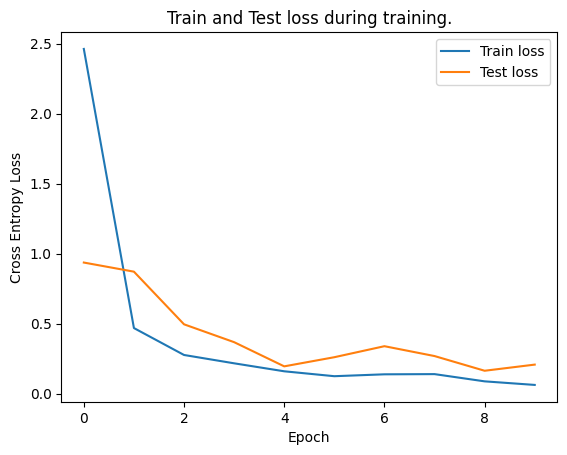

In [5]:
plt.plot(train_losses, label="Train loss")
plt.plot(test_losses, label="Test loss")
plt.legend()
plt.title("Train and Test loss during training.")
plt.ylabel("Cross Entropy Loss")
plt.xlabel("Epoch")
plt.show()

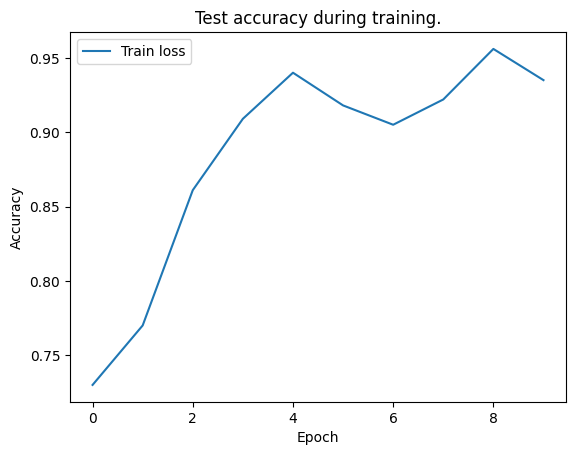

In [6]:
plt.plot(test_accs, label="Train loss")
plt.legend()
plt.title("Test accuracy during training.")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.show()